In [9]:
print("Lung Cancer Classification From Ct scan image (Kaagle Dataset)")

Lung Cancer Classification From Ct scan image (Kaagle Dataset)


In [10]:
import numpy as np
import os
import pandas as pd
import cv2 as cv
import tensorflow as tf

In [11]:
train_path ='/kaggle/input/lungcancerdataset2/lcD-2/train'

In [12]:
print(os.listdir(train_path))

['Normal cases', 'Bengin cases', 'Malignant cases']


In [13]:
data_label={
    'Normal cases':0,
    'Bengin cases' :1,
    'Malignant cases' :2,
    
}
print(data_label['Normal cases'])

0


In [14]:
X =[]
Y =[]
for img_class in os.listdir(train_path):
    for img in os.listdir(os.path.join(train_path, img_class)):
        img_path = os.path.join(train_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X.append(resize_img)
        Y.append(data_label[img_class])

In [15]:
X[0].shape

(224, 224, 3)

In [16]:
X_val =[]
Y_val =[]
val_path = '/kaggle/input/lungcancerdataset2/lcD-2/valid'
for img_class in os.listdir(val_path):
    for img in os.listdir(os.path.join(val_path, img_class)):
        img_path = os.path.join(val_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X_val.append(resize_img)
        Y_val.append(data_label[img_class])

In [17]:
test_path = '/kaggle/input/lungcancertest/test'
X_test =[]
Y_test =[]
for img_class in os.listdir(test_path):
    for img in os.listdir(os.path.join(test_path, img_class)):
        img_path = os.path.join(test_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X_test.append(resize_img)
        if img_class == 'BenginCases':
            Y_test.append(1)
        elif img_class == 'normal':
            Y_test.append(0)
        else:
            Y_test.append(2)
X_test = np.array(X_test)        
Y_test = np.array(Y_test)

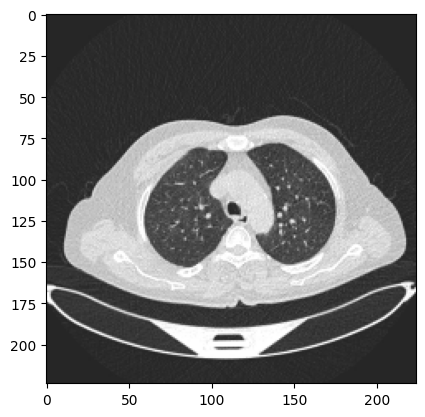

In [18]:
import matplotlib.pylab as plt
plt.imshow(X[10], cmap='gray')



In [19]:
# X[10]
np.max(X)

255

In [20]:
# import cv2
# window_name = 'Image'
# cv2.imshow(window_name, X[10])

In [21]:
X = [value / 255.0 for value in X]
X_val = [value / 255.0 for value in X_val]

x_train = np.array(X)
y_train = np.array(Y)

x_val = np.array(X_val)
y_val = np.array(Y_val)

In [22]:
np.max(x_train)

1.0

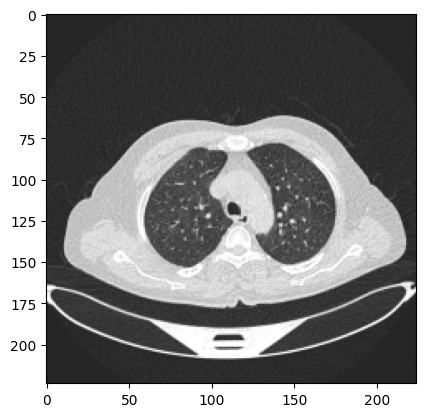

In [23]:
import matplotlib.pylab as plt
plt.imshow(x_train[10], cmap='gray')

In [24]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(1855, 224, 224, 3)
(1855,)
(476, 224, 224, 3)
(476,)


In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [26]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1484, 224, 224, 3)
(1484,)
(371, 224, 224, 3)
(371,)


In [27]:
# import matplotlib.pylab as plt
# plt.imshow(X[4], cmap='gray')

In [28]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPool2D, Dense, Conv2D, Normalization, BatchNormalization, Flatten, Dropout, Input, Activation, Concatenate, Multiply, Add
from tensorflow.keras.models import Model
# from keras.layers.serialization import activation

In [29]:
from keras.applications.vgg16 import VGG16
w ='/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_vgg16 = VGG16(
    include_top=False,
    weights= w,
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_vgg16.layers:
  layer.trainable = False

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

def cbam_block(input_feature, ratio=8):
    # Channel Attention (CA) submodule
    x = input_feature
    batch, _, _, channel = x.shape
    
    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats_ca = x1 + x2
    feats_ca = Activation("sigmoid")(feats_ca)
    feats_ca = Multiply()([x, feats_ca])

    # Spatial Attention (SA) submodule
    ## Average Pooling
    y1 = tf.reduce_mean(feats_ca, axis=-1)
    y1 = tf.expand_dims(y1, axis=-1)

    ## Max Pooling
    y2 = tf.reduce_max(feats_ca, axis=-1)
    y2 = tf.expand_dims(y2, axis=-1)

    ## Concatenat both the features
    feats_sa = Concatenate()([y1, y2])
    ## Conv layer
    feats_sa = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats_sa)
    feats_sa = Multiply()([x, feats_sa])

    # Combine CA and SA
    cbam_feature = layers.Add()([feats_ca, feats_sa])

    return cbam_feature

In [31]:
x = base_vgg16.output
# x = Conv2D(256, (3,3), padding="same", activation="relu") (x)
# x = Conv2D(128, (3,3), padding="same", activation="relu") (x)
# x = GlobalMaxPooling2D() (x)
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(4, activation = 'softmax') (x)
vgg_16_model = Model(base_vgg16.input, output)

vgg_16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [32]:
vgg_16_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [33]:
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)
# print("x_val shape:", x_val.shape)
# print("y_val shape:", y_val.shape)

x shape: (1484, 224, 224, 3)
y shape: (1484,)


In [34]:
vgg16_history = vgg_16_model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
38/38 [==============================] - 25s 230ms/step - loss: 1.0274 - accuracy: 0.5855 - val_loss: 0.7121 - val_accuracy: 0.8114
Epoch 2/30
38/38 [==============================] - 6s 146ms/step - loss: 0.6061 - accuracy: 0.8206 - val_loss: 0.4623 - val_accuracy: 0.8418
Epoch 3/30
38/38 [==============================] - 6s 146ms/step - loss: 0.4012 - accuracy: 0.8585 - val_loss: 0.3082 - val_accuracy: 0.8956
Epoch 4/30
38/38 [==============================] - 6s 147ms/step - loss: 0.2376 - accuracy: 0.9259 - val_loss: 0.2074 - val_accuracy: 0.9327
Epoch 5/30
38/38 [==============================] - 6s 147ms/step - loss: 0.1520 - accuracy: 0.9537 - val_loss: 0.1587 - val_accuracy: 0.9461
Epoch 6/30
38/38 [==============================] - 6s 149ms/step - loss: 0.1147 - accuracy: 0.9663 - val_loss: 0.1907 - val_accuracy: 0.9327
Epoch 7/30
38/38 [==============================] - 6s 150ms/step - loss: 0.0924 - accuracy: 0.9714 - val_loss: 0.1427 - val_accuracy: 0.9394
Epoch

In [35]:
vgg_16_model.evaluate(X_test,Y_test)

7/7 [==============================] - 4s 676ms/step - loss: 3.2614 - accuracy: 0.5701


[3.261350154876709, 0.5700934529304504]

In [36]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.59      0.98      0.73       123
           1       0.00      0.00      0.00        11
           2       1.00      0.03      0.05        80

    accuracy                           0.57       214
   macro avg       0.53      0.33      0.26       214
weighted avg       0.71      0.57      0.44       214

1/1 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       0.94      0.89      0.91       116
           2       0.91      0.95      0.93       141

    accuracy                           0.95       371
   macro avg       0.95      0.95      0.95       371
weighted avg       0.95      0.95      0.95       371



In [37]:
x = cbam_block(base_vgg16.layers[-1].output)
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(4, activation = 'softmax') (x)
vgg_16_cbam_model = Model(base_vgg16.input, output)

vgg_16_cbam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [38]:
vgg_16_cbam_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [39]:
vgg16_cbam_history = vgg_16_cbam_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
38/38 [==============================] - 12s 181ms/step - loss: 0.7219 - accuracy: 0.7439 - val_loss: 0.4024 - val_accuracy: 0.8687
Epoch 2/20
38/38 [==============================] - 6s 160ms/step - loss: 0.2693 - accuracy: 0.9250 - val_loss: 0.2620 - val_accuracy: 0.8788
Epoch 3/20
38/38 [==============================] - 6s 162ms/step - loss: 0.1381 - accuracy: 0.9553 - val_loss: 0.1327 - val_accuracy: 0.9428
Epoch 4/20
38/38 [==============================] - 6s 163ms/step - loss: 0.0797 - accuracy: 0.9714 - val_loss: 0.1064 - val_accuracy: 0.9562
Epoch 5/20
38/38 [==============================] - 6s 164ms/step - loss: 0.0756 - accuracy: 0.9688 - val_loss: 0.1039 - val_accuracy: 0.9495
Epoch 6/20
38/38 [==============================] - 6s 163ms/step - loss: 0.0660 - accuracy: 0.9747 - val_loss: 0.1277 - val_accuracy: 0.9394
Epoch 7/20
38/38 [==============================] - 6s 163ms/step - loss: 0.0623 - accuracy: 0.9756 - val_loss: 0.1062 - val_accuracy: 0.9428
Epoch

In [40]:
# test_path = '/kaggle/input/lung-cancer-test/test'
# X_test =[]
# Y_test =[]
# for img_class in os.listdir(test_path):
#     for img in os.listdir(os.path.join(test_path, img_class)):
#         img_path = os.path.join(test_path, img_class, img)
#         img_arr = cv.imread(img_path)
#         resize_img = cv.resize(img_arr,(224,224))
#         X_test.append(resize_img)
#         if img_class == 'BenginCases':
#             Y_test.append(1)
#         elif img_class == 'normal':
#             Y_test.append(0)
#         else:
#             Y_test.append(2)
# X_test = np.array(X_test)        
# Y_test = np.array(Y_test)

In [41]:
vgg_16_cbam_model.evaluate(X_test,Y_test)

7/7 [==============================] - 1s 123ms/step - loss: 3.0948 - accuracy: 0.5607


[3.0947763919830322, 0.5607476830482483]

In [42]:
vgg_16_cbam_model.evaluate(x_test,y_test)

12/12 [==============================] - 5s 403ms/step - loss: 0.1293 - accuracy: 0.9407


[0.12934009730815887, 0.9407008290290833]

In [43]:
p = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_cbam_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p.append(pred)


1/1 [==============================] - 0s 19ms/step


In [44]:
p1 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_cbam_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)

1/1 [==============================] - 0s 21ms/step


In [45]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, p))

              precision    recall  f1-score   support

           0       0.61      0.98      0.75       123
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        80

    accuracy                           0.56       214
   macro avg       0.20      0.33      0.25       214
weighted avg       0.35      0.56      0.43       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, p1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       0.89      0.92      0.91       116
           2       0.93      0.91      0.92       141

    accuracy                           0.94       371
   macro avg       0.94      0.94      0.94       371
weighted avg       0.94      0.94      0.94       371



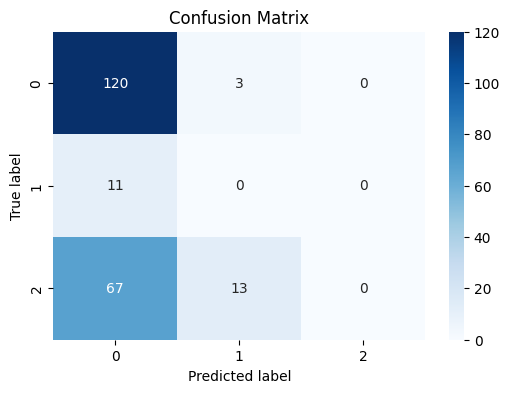

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(Y_test, p)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

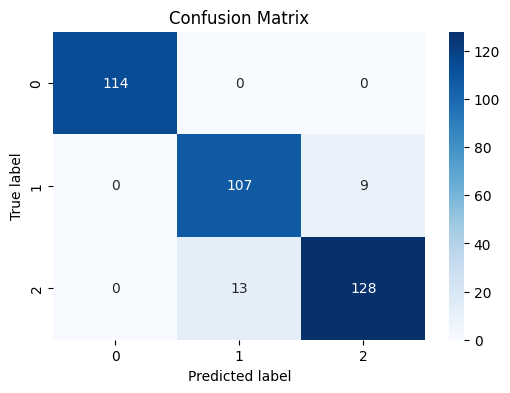

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_test, p1)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

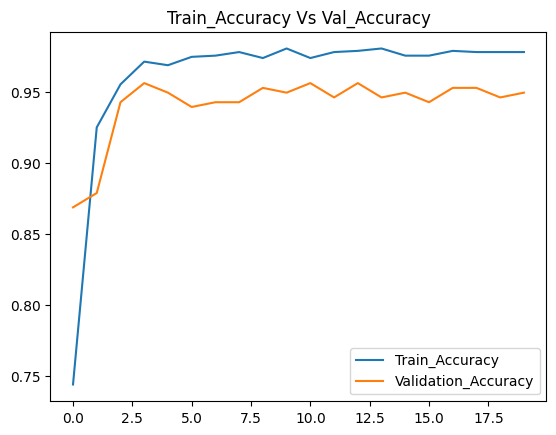

In [49]:
import matplotlib.pyplot as plt
plt.title('Train_Accuracy Vs Val_Accuracy')
plt.plot(vgg16_cbam_history.history['accuracy'], label='Train_Accuracy')
plt.plot(vgg16_cbam_history.history['val_accuracy'], label='Validation_Accuracy')
plt.legend()
plt.show();

In [50]:
w = '/kaggle/input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_inceptionResNet = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights= w,
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_inceptionResNet.layers:
    layer.trainable = False

In [51]:
import tensorflow as tf
base_InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights= "imagenet",
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_InceptionV3.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [52]:
x = base_InceptionV3.output
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(4, activation = 'softmax') (x)
InceptionV3_model = Model(base_InceptionV3.input, output)

InceptionV3_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_204 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 111, 111, 32)         96        ['conv2d_204[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_204 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_20

In [53]:
InceptionV3_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [54]:
InceptionV3_history = InceptionV3_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_data = (x_val, y_val))

Epoch 1/20
47/47 [==============================] - 17s 204ms/step - loss: 1.0210 - accuracy: 0.6024 - val_loss: 0.7700 - val_accuracy: 0.8004
Epoch 2/20
47/47 [==============================] - 4s 93ms/step - loss: 0.6236 - accuracy: 0.8066 - val_loss: 0.5039 - val_accuracy: 0.8067
Epoch 3/20
47/47 [==============================] - 4s 93ms/step - loss: 0.4141 - accuracy: 0.8470 - val_loss: 0.3854 - val_accuracy: 0.8445
Epoch 4/20
47/47 [==============================] - 4s 94ms/step - loss: 0.3453 - accuracy: 0.8544 - val_loss: 0.3530 - val_accuracy: 0.8466
Epoch 5/20
47/47 [==============================] - 4s 94ms/step - loss: 0.3217 - accuracy: 0.8760 - val_loss: 0.3249 - val_accuracy: 0.8655
Epoch 6/20
47/47 [==============================] - 4s 94ms/step - loss: 0.2797 - accuracy: 0.8996 - val_loss: 0.3005 - val_accuracy: 0.8739
Epoch 7/20
47/47 [==============================] - 4s 94ms/step - loss: 0.2406 - accuracy: 0.9090 - val_loss: 0.2614 - val_accuracy: 0.8950
Epoch 8/20


In [55]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = InceptionV3_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = InceptionV3_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.55      0.76      0.64       123
           1       0.00      0.00      0.00        11
           2       0.33      0.17      0.23        80

    accuracy                           0.50       214
   macro avg       0.29      0.31      0.29       214
weighted avg       0.44      0.50      0.45       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       0.91      0.91      0.91       116
           2       0.92      0.93      0.93       141

    accuracy                           0.94       371
   macro avg       0.95      0.94      0.94       371
weighted avg       0.94      0.94      0.94       371



In [56]:
import tensorflow as tf
base_MobNetV2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights= "imagenet",
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_MobNetV2.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [57]:
x = base_MobNetV2.output

x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
MobNet2_model = Model(base_MobNetV2.input, output)

MobNet2_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [58]:
MobNet2_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [59]:
MobNet2_model_history = MobNet2_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_data = (x_val, y_val))

Epoch 1/20
47/47 [==============================] - 10s 123ms/step - loss: 0.6983 - accuracy: 0.7487 - val_loss: 0.4200 - val_accuracy: 0.8382
Epoch 2/20
47/47 [==============================] - 3s 62ms/step - loss: 0.3651 - accuracy: 0.8625 - val_loss: 0.3066 - val_accuracy: 0.9013
Epoch 3/20
47/47 [==============================] - 3s 62ms/step - loss: 0.2697 - accuracy: 0.9009 - val_loss: 0.2281 - val_accuracy: 0.9139
Epoch 4/20
47/47 [==============================] - 3s 62ms/step - loss: 0.1918 - accuracy: 0.9387 - val_loss: 0.1601 - val_accuracy: 0.9580
Epoch 5/20
47/47 [==============================] - 3s 63ms/step - loss: 0.1422 - accuracy: 0.9508 - val_loss: 0.1718 - val_accuracy: 0.9202
Epoch 6/20
47/47 [==============================] - 3s 62ms/step - loss: 0.1108 - accuracy: 0.9629 - val_loss: 0.1290 - val_accuracy: 0.9475
Epoch 7/20
47/47 [==============================] - 3s 62ms/step - loss: 0.1058 - accuracy: 0.9670 - val_loss: 0.1752 - val_accuracy: 0.9223
Epoch 8/20


In [60]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = MobNet2_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = MobNet2_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.57      0.97      0.71       123
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        80

    accuracy                           0.56       214
   macro avg       0.19      0.32      0.24       214
weighted avg       0.33      0.56      0.41       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       0.92      0.92      0.92       116
           2       0.94      0.94      0.94       141

    accuracy                           0.95       371
   macro avg       0.95      0.95      0.95       371
weighted avg       0.95      0.95      0.95       371



In [61]:
base_ResNet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    classifier_activation="relu",
)

94765736/94765736 [==============================] - 0s 0us/step


In [62]:
x = base_ResNet50.output

x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
ResNet50_model = Model(base_ResNet50.input, output)

ResNet50_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [63]:
ResNet50_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [64]:
ResNet50_model_history = ResNet50_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_data = (x_val, y_val))

Epoch 1/20
47/47 [==============================] - 59s 449ms/step - loss: 0.4804 - accuracy: 0.8100 - val_loss: 1.8365 - val_accuracy: 0.3067
Epoch 2/20
47/47 [==============================] - 16s 350ms/step - loss: 0.4370 - accuracy: 0.8228 - val_loss: 1.9871 - val_accuracy: 0.3403
Epoch 3/20
47/47 [==============================] - 16s 351ms/step - loss: 0.3547 - accuracy: 0.8477 - val_loss: 3.1686 - val_accuracy: 0.3067
Epoch 4/20
47/47 [==============================] - 16s 345ms/step - loss: 0.3451 - accuracy: 0.8524 - val_loss: 3.5284 - val_accuracy: 0.3067
Epoch 5/20
47/47 [==============================] - 16s 343ms/step - loss: 0.2969 - accuracy: 0.8747 - val_loss: 3.6293 - val_accuracy: 0.3067
Epoch 6/20
47/47 [==============================] - 16s 344ms/step - loss: 0.2450 - accuracy: 0.9104 - val_loss: 3.8423 - val_accuracy: 0.3067
Epoch 7/20
47/47 [==============================] - 16s 345ms/step - loss: 0.1996 - accuracy: 0.9286 - val_loss: 3.7325 - val_accuracy: 0.3067

In [65]:
p1 = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = ResNet50_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p1))

p2 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = ResNet50_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p2.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p2))

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.00      0.00      0.00        11
           2       0.37      1.00      0.54        80

    accuracy                           0.37       214
   macro avg       0.12      0.33      0.18       214
weighted avg       0.14      0.37      0.20       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       114
           1       0.83      0.47      0.60       116
           2       0.81      0.68      0.74       141

    accuracy                           0.71       371
   macro avg       0.75      0.72      0.70       371
weighted avg       0.76      0.71      0.70       371

